# Titanic Kaggle Challenge

In [1]:
import numpy as np
import pandas as pd
import graphviz 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

sns.set()

## Doel
Voorspellen wie wel en wie niet de ramp op de Titanic heeft overleefd.

***

## Data inladen
- Kaggle voorziet de bestanden `test.csv` en `train.csv`.
    - `train.csv` wordt gebruikt om de modellen te trainen
    - De voorspellingen gemaakt met `test.csv` dienen te worden ingeleverd op Kaggle om de juistheid te horen
- `PassengerId` wordt de index van de DataFrame's.

In [2]:
df_test = pd.read_csv("./data/test.csv")
df_test.set_index('PassengerId', inplace=True)
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
df_train = pd.read_csv("./data/train.csv")
df_train.set_index('PassengerId', inplace=True)
df_train.sample(5, random_state=42)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
710,1,3,"Moubarek, Master. Halim Gonios (""William George"")",male,NaN,1,1,2661,15.2458,NaN,C
440,0,2,"Kvillner, Mr. Johan Henrik Johannesson",male,31.0,0,0,C.A. 18723,10.5000,NaN,S
841,0,3,"Alhomaki, Mr. Ilmari Rudolf",male,20.0,0,0,SOTON/O2 3101287,7.9250,NaN,S
721,1,2,"Harper, Miss. Annie Jessie ""Nina""",female,6.0,0,1,248727,33.0000,NaN,S
40,1,3,"Nicola-Yarred, Miss. Jamila",female,14.0,1,0,2651,11.2417,NaN,C


## Kolommen droppen en datatypes aanpassen

- `Name`, `Ticket` en `Cabin` bevatten tekst, hier worden de vingers niet aan gebrand.
- `Age` wordt gevuld met een getal binnen één $\sigma$ van de gemiddelde leeftijd.
- `Pclass`, `Sex` en `Embarked` worden omgezet naar categorische datatypen.
- `Survived` wordt omgezet van 0/1 naar booleans

In [4]:
dfs = [df_test, df_train]

for df in dfs:
    df.drop(columns=["Name", "Ticket", "Cabin"], inplace=True)
    
    mean, std = df["Age"].mean(), df["Age"].std()
    is_null = df["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size=is_null)
    
    age_slice = df["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    
    df["Age"] = age_slice
    df["Age"] = df["Age"].astype(int)
    
    df["Pclass"] = df["Pclass"].astype('category')
    df["Sex"] = df["Sex"].astype('category')
    df["Embarked"] = df["Embarked"].astype('category')
    
df_train["Survived"] = df_train["Survived"].astype('bool')
df_train.dtypes

Survived        bool
Pclass      category
Sex         category
Age            int32
SibSp          int64
Parch          int64
Fare         float64
Embarked    category
dtype: object

## Missende waarden vullen
- `df_test` mist maar één waarde bij `Fare`.
    - Deze waarde wordt opgevuld met het gemiddelde van `Fare`. 
- `df_train` mist maar twee waarden bij `Embarked`.
    - Deze waarden worden opgevuld met de meest voorkomende waarde van `Embarked`: $\text{S}$

In [5]:
df_test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        1
Embarked    0
dtype: int64

In [6]:
df_test[["Fare"]] = df_test[["Fare"]].fillna(value=df_test["Fare"].mean())
df_test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [7]:
df_train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [8]:
df_train[["Embarked"]] = df_train[["Embarked"]].fillna(value="S")
df_train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Data normaliseren

- De vier kolommen met getallen - `Age`, `Fare`, `SibSp`, `Parch` - worden genormaliseerd.
- De Standard Scaler wordt ge-fit met `df_train`.
- `df_test` wordt genormaliseerd volgens de parameters/verhoudingen waarmee `scalar` is ge-fit.

In [9]:
scaler = StandardScaler()
df_train[["Age", "Fare", "SibSp", "Parch"]] = scaler.fit_transform(df_train[["Age", "Fare", "SibSp", "Parch"]])
df_train.sample(5, random_state=42)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
710,True,3,male,0.848003,0.432793,0.767630,-0.341452,C
440,False,2,male,0.108480,-0.474545,-0.473674,-0.437007,S
841,False,3,male,-0.704996,-0.474545,-0.473674,-0.488854,S
721,True,2,female,-1.740329,-0.474545,0.767630,0.016023,S
40,True,3,female,-1.148710,0.432793,-0.473674,-0.422074,C


In [10]:
df_test[["Age", "Fare", "SibSp", "Parch"]] = scaler.transform(df_test[["Age", "Fare", "SibSp", "Parch"]])
df_test.sample(5, random_state=42)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1213,3,male,-0.335234,-0.474545,-0.473674,-0.502864,C
1216,1,female,0.700099,-0.474545,-0.473674,3.606793,S
1280,3,male,-0.631043,-0.474545,-0.473674,-0.492378,Q
948,3,male,0.404289,-0.474545,-0.473674,-0.489442,S
1045,3,female,0.478242,-0.474545,2.008933,-0.403115,S


## DataFrames met dummykolommen maken

- Voor de categorische kolommen `Pclass`, `Sex` en `Embarked` worden dummykolommen aangemaakt

In [11]:
df_train_dum = pd.get_dummies(df_train)
df_train_dum.sample(5, random_state=42)

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,
710,True,0.848003,0.432793,0.767630,-0.341452,0,0,1,0,1,1,0,0
440,False,0.108480,-0.474545,-0.473674,-0.437007,0,1,0,0,1,0,0,1
841,False,-0.704996,-0.474545,-0.473674,-0.488854,0,0,1,0,1,0,0,1
721,True,-1.740329,-0.474545,0.767630,0.016023,0,1,0,1,0,0,0,1
40,True,-1.148710,0.432793,-0.473674,-0.422074,0,0,1,1,0,1,0,0


In [12]:
df_test_dum = pd.get_dummies(df_test)
df_test_dum.sample(5, random_state=42)

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
1213,-0.335234,-0.474545,-0.473674,-0.502864,0,0,1,0,1,1,0,0
1216,0.700099,-0.474545,-0.473674,3.606793,1,0,0,1,0,0,0,1
1280,-0.631043,-0.474545,-0.473674,-0.492378,0,0,1,0,1,0,1,0
948,0.404289,-0.474545,-0.473674,-0.489442,0,0,1,0,1,0,0,1
1045,0.478242,-0.474545,2.008933,-0.403115,0,0,1,1,0,0,0,1


## Correlatiematrix plotten

[]

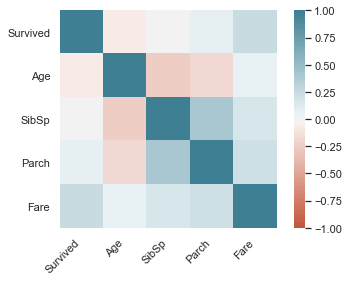

In [13]:
corr = df_train.corr()
ax = sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')

plt.plot()

## Test/Train-split

- De matrix `X` bevat alle features van `df_train`.
- De vector `y` bevat de labels van `df_train`.

In [14]:
X = df_train_dum.drop("Survived", axis=1)
y = df_train_dum["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Logistic Regression aanmaken, fitten en scoren

- Logistic Regression is een goede optie aangezien een opvarende alleen óf overleefd óf overlijd.
- In $\pm$ 80% van de voorspellingen is Logistic Regression juist.

In [15]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
clf_pred = clf.predict(df_test_dum)

clf.score(X_test, y_test)

0.8026905829596412

## Decision Tree

- Decision Tree's zijn een goede optie aangezien dit algoritme de keuzes uitlegbaar en transparant maakt.

In [16]:
from sklearn import tree
decTree = tree.DecisionTreeClassifier(max_depth=4, random_state=42)
decTree.fit(X_train, y_train)
decTree_pred = decTree.predict(df_test_dum)

decTree.score(X_test, y_test)

0.8071748878923767

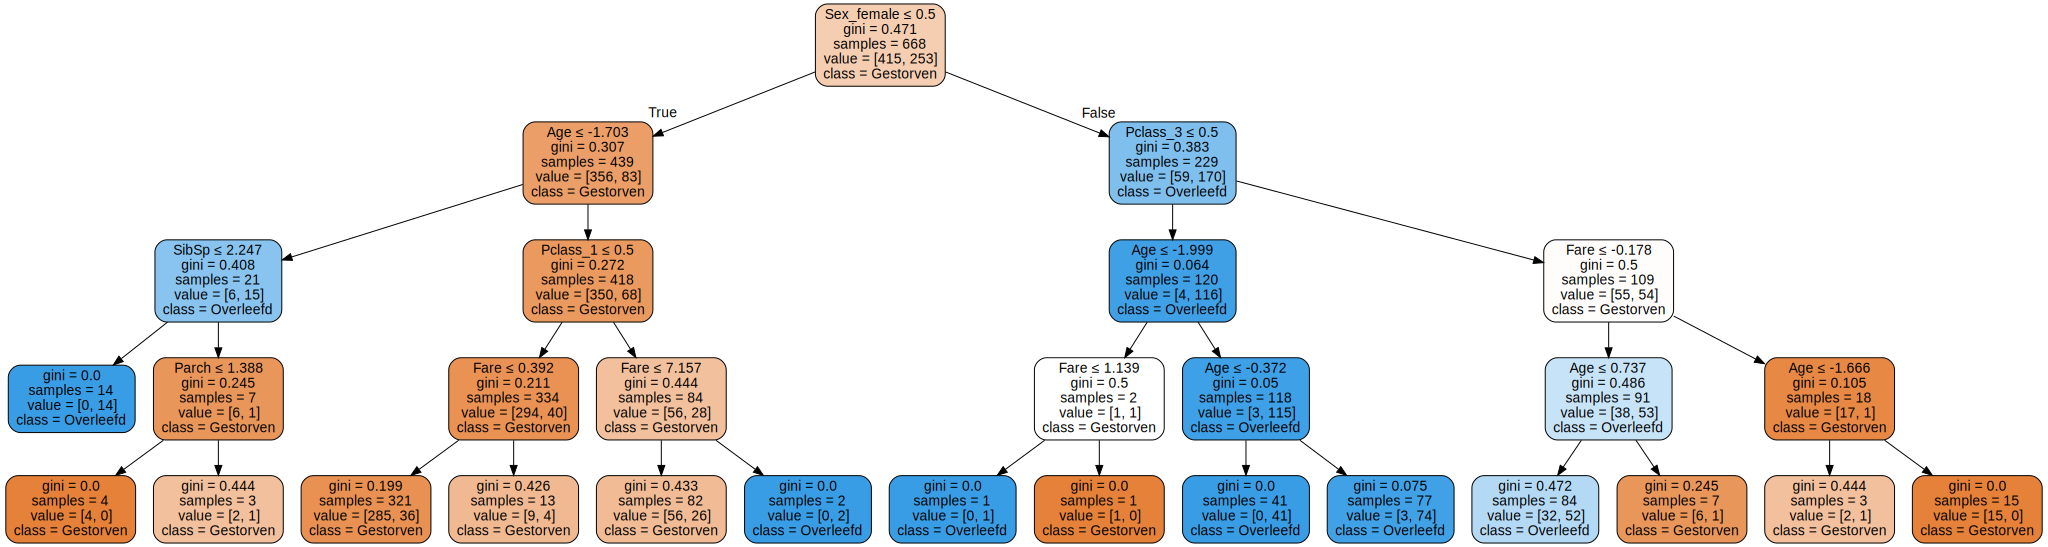

In [17]:
dot_data = tree.export_graphviz(decTree, out_file=None,
                     feature_names=df_test_dum.columns,
                     class_names=["Gestorven", "Overleefd"],
                     filled=True, rounded=True,
                     special_characters=True)
graphviz.Source(dot_data)

## Random Forest

- Random Forests kunnen enige verbetering opleveren ten opzichte van Decision Trees
    - Te zien is dat dit $\pm$ 2% is.

In [18]:
rndForest = RandomForestClassifier(max_depth=4, random_state=42)
rndForest.fit(X, y)

rndForest.score(X_test, y_test)

0.820627802690583

## Bronnen:
- Kaggle. (2012, 28 september). Titanic: Machine Learning from Disaster | Kaggle. Geraadpleegd op 11 maart 2020, van https://www.kaggle.com/c/titanic/data
- Orvakanti, P. K. (2018, 18 oktober). This will help you score 95 percentile in the Kaggle Titanic ML competition. Geraadpleegd op 11 maart 2020, van https://medium.com/@praveen.orvakanti/this-will-help-you-score-95-percentile-in-the-kaggle-titanic-ml-competition-aa2b3fd1b79b
- Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.
- Zaric, D. (2019, 15 april). Better Heatmaps and Correlation Matrix Plots in Python. Geraadpleegd op 16 maart 2020, van https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec